In [33]:
#===================
# Bruno Ugolini
#===================

# Set all the imports
import pandas as pd
import numpy as np
import math
import random
import numba
from numba import jit
from check_solution import check_solution
import matplotlib.pyplot as plt
import seaborn as sns
import time

def bank_robber_cntrlr(seed, alpha, nb_neigh, iters):
    """
    Program that oversees and 
    controls the progress of the iterations
    to optimize the bank robber path.
    
    Method
    ======
    
    The program executes as follows:
        1) run a greedy algorithm to
           maximize $/hr (including
           travel time and looting time)
        2) run an optimizer on the path
           from (1) by traveling the shortest
           distance between points in the
           path. However, for each step,
           3 nearest neighbors are selected
           and then the complete path is run
           with each. The best is chosen
           and the iteration is repeated for
           the next step.
        3) The optimized path is re-run in the
           greedy algorithm of (1) and time /
           distance savings are converted into
           the addition of more banks. Note that
           the path is check both forward and 
           backwards to check where it is most
           beneficial to add points.
        4) Two loops of simulated annealing are
           executed to optimize path further.
           Parameters for the annealing are input
           at the top level. For each step in the
           annealing, a random bank is selected.
           A random neighbor is then switched with
           this bank in the path order. If beneficial
           the switch is accepted. If not, the 
           'temperature' decay is compared to a
           random number for acceptance.
        5) Repeat (2) with this latest path.
    
    Inputs
    ======
    Note: all inputs pertain to simulated annealing.
        
    seed: used for repeatability of random number
          functions.
    alpha: the temperature decay factor for 
           simulated annealing.
    nb_neigh: number of neighbors to consider for
              the random switching during annealing.
    iters: number of iterations for annealing.
    
    Outputs
    =======
    
    loot: the money collected.
    path: the order of banks looted from start to
          penultimate to the airport.
    """

    random.seed(seed)
    
    start_time = time.time()
    
    # Read in the data
    print(f"Reading in data into df.")
    df = pd.read_csv('bank_data.csv')
    
    # Step 1. Call the greedy algorithm to
    # initiate the process
    print(f"Running greedy algorithm.")
    loot_0, path_0 = bank_robber(df.copy())
    
    # Step 2. Run the path through the
    # simple optimizer
    print(f"Running simple path optimizer.")
    path_b = opt_distance(df.copy(), path_0)
    
    # This new optimized path must be
    # checked in both directions since
    # adding points at either the front
    # or back end may be optimal.
    
    # Step 3. Check the results forward and backward
    loot_1, path_1 = check_fwd_bwd(df.copy(), loot_0, path_0, path_b)

    # Step 4. Simulated Annealing
    
    # Step 4A. First run of simulated annealing to 
    # get a better distance between these points.
    path_c = simulated_annealing(df.copy(), path_1, alpha, nb_neigh, iters)
    
    # Check the results ...
    loot_5a, path_5a = check_fwd_bwd(df.copy(), loot_1, path_1, path_c)
    
    # Step 4B. Second run of simulated annealing to 
    # get a better distance between these points.
    path_d = simulated_annealing(df.copy(), path_5a, alpha, nb_neigh, iters)
    
    # Step 5. Check the results one final time
    loot_5, path_5 = check_fwd_bwd(df.copy(), loot_5a, path_5a, path_d)
    
    # Check solution using Matt's checker
    print(f"Running Matt's check_solution")
    check_solution(path_5, df.copy())
    
    # Check total run time
    print(f"Total run time: {(time.time() - start_time)/60:0.3f} minutes")
    print(f"Final loot: ${loot_5:,.0f}")
    
    return loot_5, path_5

def bank_robber(df0, path=[]):
    """
    The function calculates the
    greedy path for a given node 'nxt'
    before time_left goes negative.
    
    Where additional columns to df are:
      df[:,5] or 'dist' 
                  = distance from nxt
      df[:,6] or 'trvl_loot'
                  = time to travel and 
                    loot this next point
      df[:,7] or 'gradient'
                  = loot / trvl_loot
    
    The path is calculated backwards
    from the airport at the origin.
    
    This function optionally takes in
    a path that has been further
    optimized in order to add additional 
    nodes to the path.
    
    Input:
           df : dataframe of points
         path : path to re-process if
                optimizing
                
    Output:
         loot : money collected
         path : path from 1st to last
    """
    
    # Initialize various parameters
    speed = 30 # km/hr
    x, y = (0, 0)
    time_left = 24
    loot_collected = 0
    df = df0.copy()
    
    # Check if a path was provided for
    # additional points
    if len(path) > 0:
        path = path[::-1]
        for nxt in path:
            # Add the required variables
            # to the dataframe 
            df['distance'] = np.sqrt((df.x_coordinate - x)**2 + 
                                     (df.y_coordinate - y)**2)
            df['trvl_loot'] = df.distance / speed + df['time (hr)']
            df['gradient'] = df.money / df.trvl_loot
            # Proceed down the path provided
            # collecting loot and counting time
            loot_collected += df.loc[nxt].money
            time_left -= df.loc[nxt].trvl_loot
            x, y = (df.loc[nxt].x_coordinate, df.loc[nxt].y_coordinate)
            df = df.drop(index=nxt, axis=0)
        # Check that the optimized
        # path did not exceed
        if time_left < 0:
            return -999, []
    
    # create a list for temporary rejections
    rejects = []
    
    # Proceed the greedy algorithm as long
    # as there is time and banks left to loot
    while time_left > 0 and len(df) > 0:
        
        df['distance'] = np.sqrt((df.x_coordinate - x)**2 + 
                                 (df.y_coordinate - y)**2)
        df['trvl_loot'] = df.distance / speed + df['time (hr)']
        df['gradient'] = df.money / df.trvl_loot

        # Select the best path defined by
        # the : most money for a given time
        #       to travel and loot this bank
        # Note: do not consider those temporarily
        #       rejected
        tmp = pd.concat([df,df[df.index.isin(rejects)]]).drop_duplicates(keep=False)
        nxt = tmp.idxmax()['gradient']

        # Do we have time?
        if time_left - df.loc[nxt].trvl_loot > 0:
            # if so, then loot and append to path
            x, y = (df.loc[nxt].x_coordinate, df.loc[nxt].y_coordinate)
            time_left -= df.loc[nxt].trvl_loot
            loot_collected += df.loc[nxt].money
            path.append(int(df.loc[nxt]['id']))
        
            # Remove the point
            df = df.drop(index=nxt, axis=0)     
            
            # Clear the reject list since now
            # all our distances have to be re-
            # calculated
            rejects = []
            
        elif len(df[df.trvl_loot < time_left]) == 0 :
            break
            
        else:
            rejects.append(nxt)
    
    distance = find_distance(df0.to_numpy(copy=True),np.array(path))                     
                         
    print(f"distance/time_left/loot: {distance:0.3f} / {time_left:0.3f} / ${loot_collected:,.0f}")
    
    # return loot gathered and path
    # from first visited to last.
    return loot_collected, path[::-1]

def opt_distance(df0, path):
    """
    Optimizes a given path based
    on the shortest distance between
    the points.
    
    Used to fine tune the path that
    was originally found using
    the greedy algorithm involving
    time and money constraints.
    
    Returns a path that visits
    all nodes but with a shortened
    path.
    
    For each step, 3 candidates are
    chosen as the nearest banks. For
    each of these, the remaining path
    is created and the resulting 
    distances compared. The bank with
    the best distance total is chosen.
    
    This same process is repeated for 
    the next bank.
    
    Inputs:
    df0: dataframe of bank info.
    path: current path to optimize
    
    Outputs:
    path: the new path.
    """
    
    df = df0.loc[path].copy()
    dist = 0
    new_path = []
    path = path[::-1]
    x, y = (0, 0)
    optns = 3  # number of closest banks to examine
    
    # starting from the origin
    # loop through path selecting
    # the next closest bank.
    for i in range(len(path)):
        
        df['dist'] = np.sqrt((df.x_coordinate - x)**2 +
                             (df.y_coordinate - y)**2)
        
        # find the 3 nearest points
        nxt_optns = df.dist.nsmallest(optns).index
        
        distances = {}
        
        # loop these three options 
        # and select the best as 
        # your next point
        for optn in nxt_optns:
            
            path_rest = []
            df_dum = df.copy()
            path_rest.append(int(optn))
            
            x1 = df_dum.loc[optn].x_coordinate
            y1 = df_dum.loc[optn].y_coordinate
            
            df_dum = df_dum.drop(index=optn, axis=0)

            dfnp = df_dum.to_numpy(copy=True)
        
            pt = np.array(path_rest)
            lgth = len(path) - i - 1  # remainder of the path length
            # get the rest of the path in this function
            path_rest = rest_of_path(dfnp, pt, x1, y1, lgth)
    
            a = new_path.copy()
            a.extend(path_rest)

            distances[int(optn)] = find_distance(df0.to_numpy(copy=True),np.array(a))
        
        nxt = min(distances, key=distances.get)
        
        new_path.append(nxt)
        
        x = df.loc[nxt].x_coordinate
        y = df.loc[nxt].y_coordinate
        
        df = df.drop(index=nxt, axis=0)
    
    # return the path from first
    # visited to last.
    return new_path[::-1]

def rest_of_path(df, pt, x, y, lgth):
    """
    Generates the remainder of a path
    using minimum distance to the next
    bank as the criteria.
    
    Input:
    df: dataframe of banks
    pt: prior path points array
    x: starting x location
    y: starting y location
    lgth: number of iterations to run
    
    Output:
    the remainder of the path
    """
    
    while lgth > 0:
        df[:,5] = np.sqrt((df[:,1] - x)**2 + 
                          (df[:,2] - y)**2)
        min_d = min(df[:,5])
        idx, x, y, _, _, _ = df[np.where(df[:,5] == min_d)].flatten()
        pt = np.append(pt, idx)
        npw = np.where(df[:,0] == idx)
        df[npw[0],1] = 1000
        lgth -= 1
    return pt

def check_fwd_bwd(df, lt_old, pt_old, pt_new):
    """
    Check a new path in both the forward
    and backward direction for improvement.
    
    Input:
    df: banks dataframe
    lt_old: current loot total
    pt_old: current path
    pt_new: new path to check agains
    
    Output:
    lt: new loot
    pt: new path
    """
    print(f"Check new path forward ...")
    lt_a, pt_a = check_for_improvement(df.copy(), lt_old, pt_old, pt_new)
    print(f"Check new path backward ...")
    lt, pt = check_for_improvement(df.copy(), lt_a, pt_a, pt_new[::-1])
    
    return lt, pt
   
def check_for_improvement(df, loot_0, path_0, path_n):
    """
    Takes a path and:
    1) Verifies if points can be added to increase
       the loot.
    2) Runs the path optimizer.
    3) Re-run bank_robber to add points if possible.
    
    Input:
    df: bank dataframe
    loot_0, path_0: status to compare to.
    path_n: new path for checking
    
    Output:
    loot, path: best outcome or previous input.
    """
    # Check for improvement
    print(f"\tChecking results ...")
    loot_2, path_2 = bank_robber(df, path=path_n)
    if loot_2 > loot_0:
        print(f"\t\tLoot was improved ...")
        # Check if we saved enough time
        # to add another point
        if len(path_2) > len(path_n):
            # Optimize path again
            # and re-run robber
            path_3 = opt_distance(df.copy(), path_2)
            loot_4, path_4 = bank_robber(df.copy(), path=path_3)
            if loot_4 > loot_2:
                print(f"\t\t\tPoints were added to path ...")
                loot_2 = loot_4
                path_2 = path_4
        else:
            # Optimize path again
            # and re-run robber
            print(f"\t\t\tNo points were added to path ...")
            path_3 = opt_distance(df.copy(), path_2)
            loot_2, path_2 = bank_robber(df.copy(), path=path_3)
        return loot_2, path_2
    else:
        print(f"\t\tFailed with loot = {loot_2}")
        return loot_0, path_0

def find_distance(df, path):
    """
    Find the total distance
    traveled in the path
    from last to first.
    
    Input:
         df : dataframe of banks
       path : path to process from
              last to first
              
    Output:
       dist : total distance traveled
    """
    
    dist = 0
    x = 0
    y = 0
    cols = df.shape[1]
    
    for i in range(len(path)):
        node = int(path[i])
        
        if cols == 8:
            _, x1, y1, _, _, _, _, _ = df[np.where(df[:,0] == node)].flatten()
        elif cols == 5:
            _, x1, y1, _, _ = df[np.where(df[:,0] == node)].flatten()
        elif cols == 6:
            _, x1, y1, _, _, _ = df[np.where(df[:,0] == node)].flatten()
        elif cols == 9:
            _, x1, y1, _, _, _, _, _, _ = df[np.where(df[:,0] == node)].flatten()

        dist += math.sqrt((x1-x)**2 + (y1-y)**2)
        
        x = x1
        y = y1
    
    return dist

def simulated_annealing(df0, path_0, alpha, nb_neigh, iters):
    """
    Executes a simulated annealing on 
    a path to optimize overall path 
    distance.
    
    Inputs:
    df0: bank dataframe
    path_0: provided path
    alpha: temperature decay parameter
    nb_neigh: number of closest neighbors to consider
    iters: number of iterations to run
    
    Output:
    optimized path
    """
    
    path = np.asarray(path_0[::-1], dtype=np.int32)
    dist_0 = find_distance(df0.to_numpy(copy=True),path)
    
    df = df0.loc[path_0]
    path = path_0.copy()
    t = 1
        
    print(f"Starting dist: {dist_0:0.3f}")

    for i in range(iters):
        
        # Select a random point
        cntr = random.sample(set(path), 1)

        # find the neighbors
        kns = knn(df.copy(), cntr[0], min([nb_neigh, len(path)]))

        # Check if we can optimize using
        # the 2-Opt algorithm.
        # USING THE NEIGHBOR MODE ON
        swap = random.sample(set(kns), 2)
        
        # calculate the new temperature
        t *= (1/alpha)
            
        # Perform the swap into a path copy
        a, b = (path.index(swap[0]), path.index(swap[1]))
        path1 = path.copy()
        path1[b], path1[a] = swap
     
        # Get the new distance (note: already reversed)
        dist_new = find_distance(df.to_numpy(copy=True),path1)
        
        # Start the annealing logic
        delta = dist_new - dist_0
        delta_c = delta / dist_0

        if delta < 0:
            # Always accept an improvement
            print(f"\t\t\t... accepted better")
            print(f"n: {i:5.0f}; dist_new: {dist_new:0.3f} vs dist_old: {dist_0:0.3f}")
            path = path1.copy()
            dist_0 = dist_new
        elif delta == 0:
            pass
        else:
            # Annealing
            # calculate delta fraction
            acceptance_prob = math.exp(-delta_c*t)
            
            # accept against uniform probability
            gen_prob = random.uniform(0,1)
            if acceptance_prob > gen_prob:
                print(f"\t\t\t\t\t... delta: {delta:0.3f}; delta_c: {delta_c:0.3f} t: {t:0.4f}")
                print(f"\t\t\t\t\t... accepted worse: {gen_prob:0.3f} vs {acceptance_prob:0.3f}")
                path = path1.copy()
                dist_0 = dist_new
        
    return path[::-1]

def knn(df, node, nb):
    """
    Get the nb nearest neighbors
    of node in df.
    
    Inputs:
          df : dataframe of banks
        node : index of point to consider
          nb : number of neighbors to get
          
    Output:
         kns : indices of the nb neighbors
    """
    
    x = df.loc[node].x_coordinate
    y = df.loc[node].y_coordinate
    
    df['dist'] = np.sqrt((df.x_coordinate - x)**2 +
                         (df.y_coordinate - y)**2)
        
    kns = df.dist.nsmallest(nb).index
    
    return kns

In [34]:
loot, path = bank_robber_cntrlr(12345, 0.8, 5, 10000)

Reading in data into df.
Running greedy algorithm.
distance/time_left/loot: 210.754 / 0.045 / $14,159,300
Running simple path optimizer.
Check new path forward ...
	Checking results ...
distance/time_left/loot: 136.193 / 0.042 / $15,030,700
		Loot was improved ...
distance/time_left/loot: 130.663 / 0.001 / $15,127,800
			Points were added to path ...
Check new path backward ...
	Checking results ...
distance/time_left/loot: 141.646 / 0.011 / $15,134,300
		Loot was improved ...
distance/time_left/loot: 130.092 / 0.001 / $15,288,200
			Points were added to path ...
Starting dist: 130.092
					... delta: 6.264; delta_c: 0.048 t: 1.2500
					... accepted worse: 0.855 vs 0.942
					... delta: 1.613; delta_c: 0.012 t: 1.5625
					... accepted worse: 0.162 vs 0.982
					... delta: 0.568; delta_c: 0.004 t: 1.9531
					... accepted worse: 0.562 vs 0.992
			... accepted better
n:     3; dist_new: 138.523 vs dist_old: 138.538
					... delta: 0.633; delta_c: 0.005 t: 3.0518
					... accepted worse

			... accepted better
n:   178; dist_new: 154.708 vs dist_old: 154.788
			... accepted better
n:   187; dist_new: 154.520 vs dist_old: 154.708
			... accepted better
n:   210; dist_new: 152.004 vs dist_old: 154.520
			... accepted better
n:   235; dist_new: 151.662 vs dist_old: 152.004
			... accepted better
n:   237; dist_new: 148.606 vs dist_old: 151.662
			... accepted better
n:   241; dist_new: 145.142 vs dist_old: 148.606
			... accepted better
n:   260; dist_new: 145.138 vs dist_old: 145.142
			... accepted better
n:   272; dist_new: 144.502 vs dist_old: 145.138
			... accepted better
n:   280; dist_new: 144.253 vs dist_old: 144.502
			... accepted better
n:   305; dist_new: 144.239 vs dist_old: 144.253
			... accepted better
n:   313; dist_new: 143.994 vs dist_old: 144.239
			... accepted better
n:   349; dist_new: 143.350 vs dist_old: 143.994
			... accepted better
n:   390; dist_new: 142.637 vs dist_old: 143.350
			... accepted better
n:   400; dist_new: 141.895 vs dist_old: 

In [53]:
print(path)

[4674, 6169, 279, 2226, 5873, 9880, 173, 5563, 2015, 70, 3005, 1081, 7583, 6934, 865, 3466, 444, 1660, 8949, 2162, 488, 5327, 7665, 5166, 9640, 6022, 2626, 8231, 8846, 6339, 6266, 3585, 4629, 9583, 1684, 790, 2463, 4494, 3089, 4807, 524, 9228, 5836, 5298, 507, 3665, 5572, 4794, 6535, 2190, 7772, 5944, 2472, 6295, 5440, 7907, 7595, 6375, 754, 359, 3683, 8562, 557, 3914, 1966, 6254, 4422, 1455, 7494, 2639, 5971, 3340, 8375, 6759, 9653, 781, 8690, 4605, 1757, 8355, 8503, 8436, 7064, 6317, 3798, 3516, 433, 4610, 9546, 5627, 7801, 3613, 58, 2, 5631, 1372, 951, 5377, 9881, 670, 9275, 9469, 4492, 5892, 5200, 2590, 5155, 4627, 9736, 1723, 3773, 2656, 8206, 5126, 5296, 9378, 9241, 2928, 6156, 1397, 8909, 2346, 7625, 2741, 4601, 8469, 9049, 3297, 9401, 8966, 7769, 8887, 3237, 2270, 2444, 5381, 5182, 2334, 8841, 1879, 5399, 7544, 1398, 6987, 2458, 5610, 6478, 5562, 4987, 5184, 4345, 9195, 4906, 9120, 7087, 6281, 8169, 9928, 7649, 7701, 7764, 1599, 9908, 3136, 1193, 8849, 7689, 7877, 4789, 4696, 3

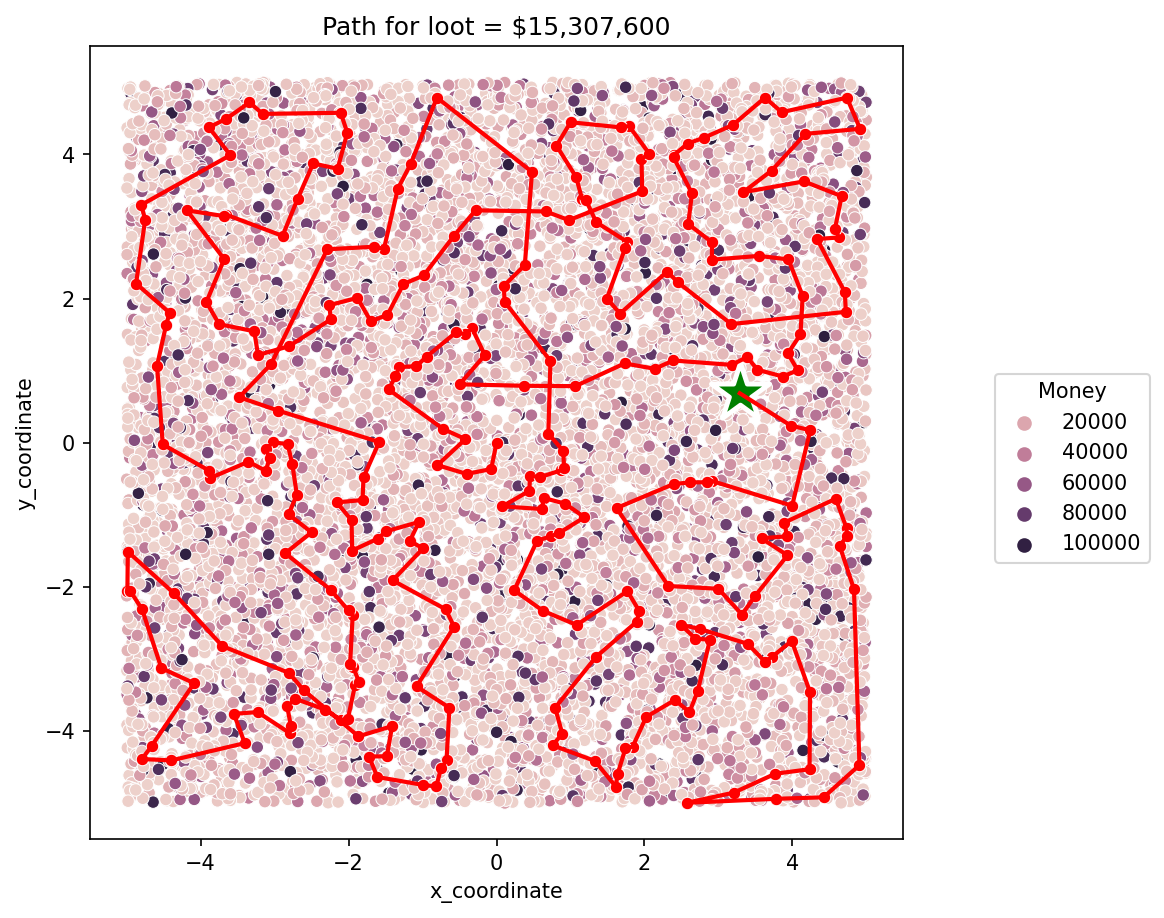

In [52]:
plt.figure(dpi=150, figsize=(7,7))
df = pd.read_csv('bank_data.csv')
title_txt = "Path for loot = " + "${:,.0f}".format(loot)
sns.scatterplot(x='x_coordinate', y='y_coordinate', data=df, hue='money').set_title(title_txt)

x_arr = [df.loc[e].x_coordinate for e in path]
y_arr = [df.loc[e].y_coordinate for e in path]

x_arr.append(0)
y_arr.append(0)
sns.scatterplot(x=x_arr,y=y_arr,color='red',sizes=30)
sns.lineplot(x=x_arr,y=y_arr,lw=2,color='red',sizes=30,sort=False)
sns.scatterplot(x=np.array([x_arr[0]]),y=np.array([y_arr[0]]),color='green',s=860,marker='*')

plt.legend(bbox_to_anchor=(1.1,0.6)).set_title('Money')